# Data-prep for "BART learns to rap"

This notebook prepares the data for the "BART learns to rap" model by loading the data taken from http://www.github.com/fpaupier/RapLyrics-Scraper


In [ ]:
import os
import pandas as pd
import numpy as np

import re
import math
import random

In [ ]:
lyrics_dir = './RapLyrics-Scraper/lyrics_US/'
lyric_files = os.listdir(lyrics_dir)

In [ ]:
with open(os.path.join(lyrics_dir, lyric_files[0]), 'r', encoding = 'utf-8') as f:
    lyrics = f.read()

In [ ]:
def create_lyric_pairs(lyrics):
    ''' Function that creates pairs of lyrics
        Args: lyrics - multiple songs by an artist in a text file
        Returns: 2 lists - source and target sentences
    '''
    source = []
    target = []

    lyrics_ = re.sub(r' \([^)]*\)', '', lyrics)
    lyrics_ = lyrics_.replace('(Hook)', '')

    lyrics_ = lyrics_.split('\n')

    # Clean up extra spaces in the lyrics
    counter = 0
    for i in range(len(lyrics_)-1):
        if lyrics_[counter] == "" and lyrics[counter+1] == "":
            lyrics_[counter+1].pop()
        counter += 1

    counter = 0
    for i in range(len(lyrics_)-1):
        if lyrics_[counter] == "" and lyrics[counter+1] == "":
            lyrics_[counter+1].pop()
        counter += 1
    # replace a "" with the word break
    for i in range(len(lyrics_)):
        if lyrics_[i] == "":
            lyrics_[i] = "break"

    counter = 0
    for i in range(len(lyrics_) - 1):
        if lyrics_[counter] != "break" and lyrics_[counter+1] != "break":
            # Use one line and target is the next line
            source.append(lyrics_[counter])
            target.append(lyrics_[counter+1])

        counter += 1

    return source, target

def noise_sentence(sentence_, percent_words, replacement_token = "<mask>"):
    '''
    Args: sentence - the sentence to noise
          percent_words - the percent of words to remove
    '''
    # Create a list item and copy
    sentence_ = sentence_.split(' ')
    sentence = sentence_.copy()

    num_words = math.ceil(len(sentence) * percent_words)

    # Create an array of tokens to sample from; don't include the last word as an option because in the case of lyrics
    # that word is often a rhyming word and plays an important role in song construction
    sample_tokens = set(np.arange(0, np.maximum(1, len(sentence)-1)))

    words_to_noise = random.sample(sample_tokens, num_words)

    # Remove redundant spaces
    sentence = re.sub(r' {2,5}', ' ', ' '.join(sentence))

    # Combine concurrent <mask> tokens into a single token; this just does two rounds of this; more could be done
    sentence = re.sub(r'<mask> <mask>', "<mask>", sentence)
    sentence = re.sub(r'<mask> <mask>', "<mask>", sentence)
    return sentence


# Noise the lyrics
The process below noises the (source) lyric and creates the training data

In [ ]:
source_lyrics = []
target_lyrics = []

for i in range(len(lyric_files[1])):
    with open(os.path.join(lyrics_dir, lyric_files[i]), 'r', encoding = 'utf-8') as f:
        lyrics = f.read()
        a, b = create_lyric_pairs(lyrics)
        source_lyrics.extend(a)
        target_lyrics.extend(b)

In [ ]:
# Set up the dataframe
lyrics_df = pd.DataFrame({"source":source_lyrics, "target":target_lyrics})

In [ ]:
# Remove duplicates; without this there's a lot of repetitiveness in the lyrics generated
lyrics_df = lyrics_df.drop_duplicates(subset = 'source')
lyrics_df = lyrics_df.drop_duplicates(subset = 'target')

In [ ]:
# Clean out the lyrics that contain a ":"; this was specific to some lyrics and created some
lyrics_df = lyrics_df[~lyrics_df.source.str.contains(":")]
lyrics_df = lyrics_df[~lyrics_df.target.str.contains(":")]
lyrics_df = lyrics_df[lyrics_df.target != "break"]


In [ ]:
# Noise the source sentences
lyrics_df['source'] = lyrics_df['source'].apply(lambda x: noise_sentence(x, 0.25))

In [ ]:
lyrics_df.to_csv("lyrics_simple_noised.csv", index = False)

(array([4.99721e+05, 1.72000e+02, 5.40000e+01, 3.10000e+01, 9.00000e+00,
        1.00000e+00, 3.00000e+00, 3.00000e+00, 3.00000e+00, 3.00000e+00]),
 array([  1. ,  43.6,  86.2, 128.8, 171.4, 214. , 256.6, 299.2, 341.8,
        384.4, 427. ]),
 <a list of 10 Patch objects>)

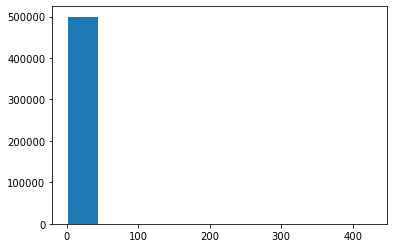

In [ ]:
# Out of interest take a look at the distribution of sentence lengths
# It turns out there was something a bit funny going on here, but as the as the tokenizer limits the length of the sentences
# fed to the model, it's not really an issue (aside from the document with training data possibly being a bit larger than it needs to be)
import matplotlib.pyplot as plt

length_of_sent = []
for i in range(500000):
    length_of_sent.append(len(lyrics_df.iloc[i, 1].split(' ')))

plt.hist(length_of_sent)

In [ ]:
# For reference, the longest sentence 400 sentences from the end of the list was only 31 tokens long
length_of_sent.sort()
length_of_sent[-400]

31